<a href="https://colab.research.google.com/github/iitmcvg/InterIIT_2021/blob/main/Final_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from sklearn import decomposition

import mlflow

# n = no. of classes
def get_confusion_matrix(true_labels, pred_labels,n):
    
    cm = metrics.confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(cm, range(n), range(n))
    heatmap = sn.heatmap(df_cm)
    figure = heatmap.get_figure()
    path = 'run_latest/conf_mat.png'
    figure.savefig(path, dpi=400)
    return path

def get_classification_report(true_labels, pred_labels, run_id, target_names):
    class_report = metrics.classification_report(true_labels,pred_labels,target_names=target_names,output_dict=True)
    
    with mlflow.start_run(run_id=run_id):
        for key in target_names:
            mlflow.log_metric(key+" f1-score",class_report[key]['f1-score'])
    df = pd.DataFrame(class_report).transpose()
    path = 'run_latest/classification_report.csv'
    df.to_csv(path)
    return path


def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)
    path = 'run_latest/pca_analysis.png'
    fig.savefig(path)
    return path

def get_pca_plot(test_dataset_dir, model, classes):

    IMG_SIZE=224
    NUM_CLASSES=48

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dataset_dir,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE))

    base_model = EfficientNetB0(include_top=False, weights='imagenet')
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    prediction_layer = tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #y = rescale(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    outputs = global_average_layer(x)

    model1 = tf.keras.Model(inputs, outputs)
    model1.set_weights(model.get_weights()[:len(model1.get_weights())]) 


    intermediates = []
    labels = []

    for x, y in test_dataset:
        output = list(model1.predict(x))
        intermediates.extend(output)
        labels.extend(list(y))

    output_pca_data = get_pca(intermediates)
    path = plot_representations(output_pca_data, labels, classes)
    return path

def model_eval_fns(test_dataset_dir, model_path, classes, run_id):

    IMG_SIZE=224
    NUM_CLASSES=48

    model = tf.keras.models.load_model(model_path)
    # Show the model architecture
    model.summary()

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dataset_dir,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE))

    y1 = np.array([]) 
    y2 = np.array([])
    for x, y in test_dataset:
        y_true=np.argmax(model.predict(x),axis=1)
        y1=np.append(y1,y_true)
        y2=np.append(y2,y.numpy())
    
    path1 = get_confusion_matrix(y1, y2, NUM_CLASSES)
    path2 = get_classification_report(y1, y2, run_id, target_names=classes.values())
    path3 = get_pca_plot(test_dataset_dir, model, classes)

    with mlflow.start_run(run_id=run_id):
        mlflow.log_artifact(path1)
        mlflow.log_artifact(path2)
        mlflow.log_artifact(path3)

def predict(x, model, csv_file):
  sign_names = pd.read_csv('/content/drive/MyDrive/signnames_added_classes.csv')

  top5softmax = np.zeros((5,1))

  top5softmax = heapq.nlargest(5, range(NUM_CLASSES), model.predict(x).take)
  output_dict = {}

  for i in range(5):
    prob = model.predict(x)[top5softmax[i]]
    output_dict.add(prob, sign_names["SignName"][top5softmax[i]])

    with open(csv_file, 'w') as f:
      for key in output_dict.keys():
        f.write("%d, %s\n" % (key, output_dict[key]))

if __name__ == "__main__":
    test_dataset_dir = "/home/lordgrim/Final_interiit/datasets/Test_dataset_48_classes"
    model_path = "/home/lordgrim/Final_interiit/latest_model"
    model_eval_fns(test_dataset_dir, model_path, classes)

In [ ]:
import pandas as pd

sign_names = pd.read_csv('/content/drive/MyDrive/signnames_added_classes.csv')

In [ ]:
sign_names["SignName"][0]

'Speed limit (20km/h)'

In [22]:
def predict(x, model, csv_file):
  test_dir = "/home/lordgrim/Final_interiit/datasets/Train_dummy/"
  sign_names = pd.read_csv('/content/drive/MyDrive/signnames_added_classes.csv')

  for label in os.listdir(test_dir):
    # img_path = os.listdir(test_dir+label)[0]
    img_path = random.sample(os.listdir(test_dir+label),1)[0]
    img_path = test_dir+label+"/"+img_path
    images_paths.append(img_path)
    images_labels.append(label)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    plt.figure()
    plt.imshow(image)
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image)

    top5softmax = np.zeros((5,1))
    top5softmax = heapq.nlargest(5, range(NUM_CLASSES), pred.take)
    output_dict = {}

    for i in range(5):
      prob = model.predict(x)[top5softmax[i]]
      output_dict.add(prob, sign_names["SignName"][top5softmax[i]])
      with open(csv_file, 'w') as f:
        for key in output_dict.keys():
          f.write("%d, %s\n" % (key, output_dict[key]))

In [14]:
x = '/content/drive/MyDrive/GTSRB/Online-Test-sort/10/00000_00000.png'

In [17]:
from PIL import Image

im = Image.open(x)

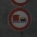

In [18]:
im

In [20]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/final_model_test.h5')